In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import parallel_backend

In [3]:
def feature_selection(df, feature_names, target='origin', top_n=20):
    mi_scores = mutual_info_classif(df[feature_names], df[target])
    mi_df = pd.DataFrame({'feature': feature_names, 'mi_score': mi_scores})
    return mi_df.sort_values('mi_score', ascending=False).head(top_n)


def train_models(X_train, y_train):
    models = {
        'SVM': SVC(kernel='linear', probability=True, random_state=42),
        'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
        'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42)
    }
    
    trained_models = {}
    
    # Cria barra de progresso personalizada
    with tqdm(models.items(), desc="Treinando modelos", unit="modelo") as pbar:
        for name, model in pbar:
            pbar.set_postfix_str(f"Treinando {name}...")
            model.fit(X_train, y_train)
            trained_models[name] = model
            pbar.set_postfix_str(f"{name} treinado")
    
    return trained_models


def evaluate_models(models, X_test, y_test, feature_names=None):
    results = {}
    
    for name, model in models.items():
        y_pred = model.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        cm = confusion_matrix(y_test, y_pred)
        
        # Importância das características (quando aplicável)
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        elif hasattr(model, 'coef_'):
            importances = np.abs(model.coef_[0])
        else:
            importances = None
        
        results[name] = {
            'report': report,
            'confusion_matrix': cm,
            'feature_importances': importances
        }
    
    return results

def plot_results(cm, importances, feature_names):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Human', 'ChatGPT'], 
                yticklabels=['Human', 'ChatGPT'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    '''
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False).head(10)
    
    plt.subplot(1, 2, 2)
    sns.barplot(data=importance_df, y='feature', x='importance', palette='viridis')
    plt.title('Top 10 Important Features')
    plt.tight_layout()
    plt.show()'''

In [4]:
df = pd.read_csv("/home/tammy.kojima/Authorship-attribution/df_pronto/df_gpt_com_features.csv")

In [5]:
feature_columns = [col for col in df.columns if col not in ['text', 'origin']]
target = 'origin' 

In [6]:
df = df.fillna(0)

In [13]:
df.head()

,text,origin,lexical_type_token_ratio,lexical_word_count,lexical_unique_words,lexical_avg_word_length,lexical_word_length_variance,lexical_stopword_ratio,stylistic_random_uppercase,stylistic_repeated_chars,...,with the,work,working,world,would,year,years,you,you are,your
0,"Our rules are the most robust, the president c...",1,0.882353,17,15,5.294118,6.442907,0.411765,0,0,...,0,0,0,0,0,0,0,0,0,0
1,...associating outsiders with danger and extre...,1,1.000000,18,18,6.000000,9.000000,0.277778,0,1,...,0,0,0,0,0,0,0,0,0,0
2,...alarms were raised in the initial stages of...,1,0.937500,32,30,4.968750,4.655273,0.437500,0,1,...,0,0,0,0,0,0,0,0,0,0
3,[The opposition] utilizes every tool to questi...,1,0.727273,22,16,5.409091,8.787190,0.500000,0,0,...,0,0,0,0,0,0,0,0,0,0
4,[The governor's] fixation with health protocol...,1,0.923077,13,12,6.153846,7.207101,0.384615,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd
import numpy as np
from tqdm import tqdm
from joblib import Parallel, delayed

def feature_selection_chunked(df, feature_names, target='origin', 
                            n_jobs=-1, chunk_size=100):
    """
    Versão otimizada com chunks e barra de progresso
    
    Parâmetros:
    - chunk_size: número de features por chunk (ajuste conforme sua RAM)
    """
    X = df[feature_names].values
    y = df[target].values
    n_features = len(feature_names)
    
    # Divide as features em chunks
    chunks = [feature_names[i:i + chunk_size] 
             for i in range(0, n_features, chunk_size)]
    
    # Função para processar cada chunk
    def process_chunk(chunk_features):
        chunk_idx = [feature_names.index(f) for f in chunk_features]
        return mutual_info_classif(
            X[:, chunk_idx], 
            y,
            n_jobs=1  # Usa 1 núcleo por chunk
        )
    
    # Paraleliza com barra de progresso
    print(f"Processando {len(chunks)} chunks de {chunk_size} features cada...")
    results = []
    with tqdm(total=len(chunks), desc="Processando chunks") as pbar:
        for result in Parallel(n_jobs=n_jobs)(delayed(process_chunk)(chunk) for chunk in chunks):
            results.extend(result)
            pbar.update(1)
    
    # Combina resultados
    mi_df = pd.DataFrame({
        'feature': feature_names,
        'mi_score': results
    }).sort_values('mi_score', ascending=False)
    
    return mi_df

In [8]:
# Exemplo de uso:
top_features = feature_selection_chunked(
    df=df,
    feature_names=feature_columns,
    target='origin',
    n_jobs=-1,  # Usa todos os núcleos
    chunk_size=100  # Ajuste conforme sua RAM
)
top_features

Processando 4 chunks de 100 features cada...


Processando chunks: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:33<00:00, 23.33s/it]


,feature,mi_score
19,structural_has_hashtag,0.305094
23,structural_hashtag_density,0.295012
4,lexical_word_length_variance,0.283570
139,https,0.225063
172,modi,0.195621
...,...,...
54,back,0.000000
272,there,0.000000
290,two,0.000000
292,under,0.000000


In [9]:
top_features.to_csv("/home/tammy.kojima/Authorship-attribution/df_pronto/top_features_gpt2.csv", index=False)

In [11]:
import pandas as pd
top_features = pd.read_csv("/home/tammy.kojima/Authorship-attribution/df_pronto/top_features_gpt2.csv")
top_features = top_features.head(20)

In [12]:
top_features

,feature,mi_score
0,structural_has_hashtag,0.305094
1,structural_hashtag_density,0.295012
2,lexical_word_length_variance,0.283570
3,https,0.225063
4,modi,0.195621
5,co,0.191462
6,structural_has_url,0.190182
7,https co,0.188236
8,structural_url_density,0.186571
9,structural_extra_spaces,0.167598


In [9]:
from sklearn.model_selection import train_test_split
X = df[top_features['feature'].tolist()]
y = df['origin']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [21]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [22]:
y_pred = log_reg.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)
cm = confusion_matrix(y_test, y_pred)

In [23]:
classification_report(y_test, y_pred)

'              precision    recall  f1-score   support\n\n           0       0.96      0.97      0.96     30000\n           1       0.97      0.96      0.96     30000\n\n    accuracy                           0.96     60000\n   macro avg       0.96      0.96      0.96     60000\nweighted avg       0.96      0.96      0.96     60000\n'

In [10]:
#ESSEEEE
#
#
#

from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score
import numpy as np

# Definindo o modelo
clf = RandomForestClassifier(random_state=42)

# Definindo métricas
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

# Validação cruzada (exemplo com 5 folds)
results = cross_validate(clf, X, y, cv=5, scoring=scoring)

# Exibindo resultados médios e desvio padrão
for metric in scoring.keys():
    print(f"{metric}: {np.mean(results['test_' + metric]):.4f} ± {np.std(results['test_' + metric]):.4f}")


accuracy: 1.0000 ± 0.0000
precision: 1.0000 ± 0.0000
recall: 1.0000 ± 0.0000
f1: 1.0000 ± 0.0000


In [12]:
# Dividir em treino e teste primeiro
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinar o modelo
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Fazer previsões
y_pred = rf_model.predict(X_test)

In [ ]:
model = SVC(kernel='linear', probability=True, random_state=42)

# Validação cruzada
results = cross_validate(model, X, y, cv=5, scoring=scoring)

# Exibindo resultados médios e desvio padrão
for metric in scoring.keys():
    print(f"{metric}: {np.mean(results['test_' + metric]):.4f} ± {np.std(results['test_' + metric]):.4f}")

In [ ]:
model = LogisticRegression(max_iter=1000, random_state=42)

# Validação cruzada
results = cross_validate(model, X, y, cv=5, scoring=scoring)

# Exibindo resultados médios e desvio padrão
for metric in scoring.keys():
    print(f"{metric}: {np.mean(results['test_' + metric]):.4f} ± {np.std(results['test_' + metric]):.4f}")

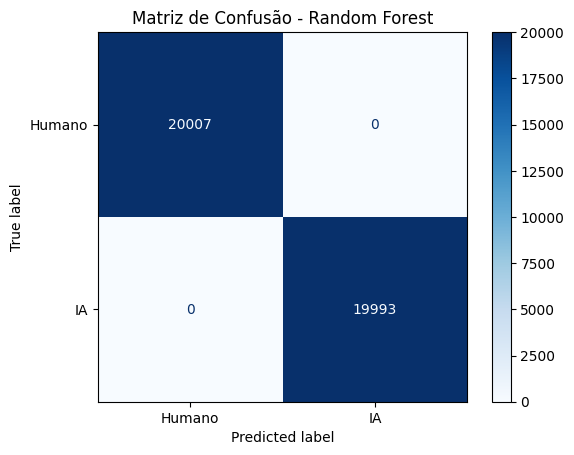

In [13]:
#ESSE
#
#
#
#

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Supondo que você já tem y_test e y_pred
cm = confusion_matrix(y_test, y_pred)  # para Random Forest

disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['Humano', 'IA'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusão - Random Forest')
plt.show()

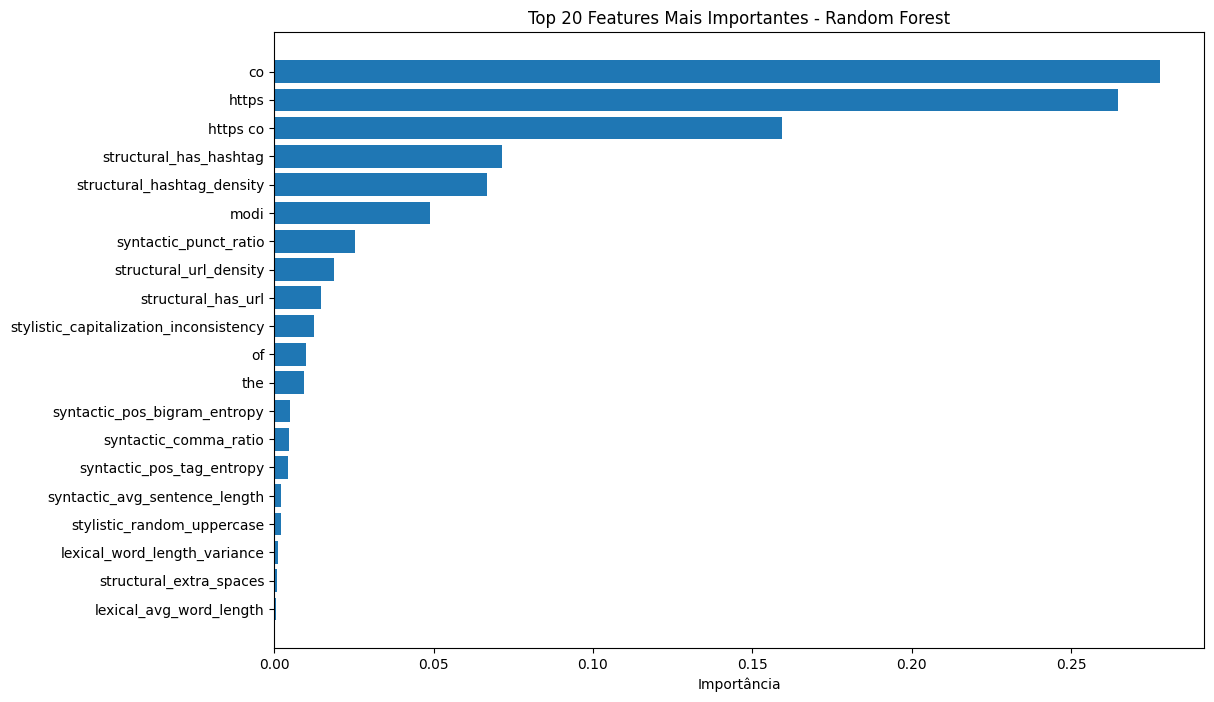

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Supondo que você tem o modelo Random Forest treinado (rf_model)
feature_importances = rf_model.feature_importances_

# Criar DataFrame com importâncias
features_df = pd.DataFrame({
    'feature': X_train.columns,  # nomes das features
    'importance': feature_importances
})

# Ordenar por importância
features_df = features_df.sort_values('importance', ascending=False)

# Visualizar top 20 features
plt.figure(figsize=(12, 8))
plt.barh(features_df['feature'][:20], features_df['importance'][:20])
plt.xlabel('Importância')
plt.title('Top 20 Features Mais Importantes - Random Forest')
plt.gca().invert_yaxis()
plt.show()

In [32]:
joblib.dump(clf, "modelo_ia_vs_humano.pkl")

['modelo_ia_vs_humano.pkl']

In [6]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import re
from collections import Counter
from math import log
import spacy
from typing import List, Dict
import joblib

/home/tammy.kojima/miniconda3/envs/meu_ambiente/lib/python3.9/site-packages/torch/cuda/__init__.py:829: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [12]:
# Configurações globais
EMOTICON_PATTERN = r'[:;=8][\-^]?[)DpP(]'
URL_PATTERN = r'http\S+|www\S+|https\S+'
MENTION_PATTERN = r'@\w+'
HASHTAG_PATTERN = r'#\w+'

# Inicializa spaCy
nlp = spacy.load("en_core_web_sm")

In [36]:
# Lista de n-grams específicos
SPECIFIC_NGRAMS = [
    ('https',), ('modi',), ('co',), ('https', 'co'), ('the',), ('of',)
]

def extract_features(text: str) -> Dict:
    """Extrai features selecionadas e n-grams específicos de uma frase"""
    doc = nlp(text)
    words = [token.text.lower() for token in doc if not token.is_punct and not token.is_space]
    word_count = len(words)
    char_count = sum(len(word) for word in words)

    # Syntactic features
    pos_tags = [token.pos_ for token in doc]
    pos_bigrams = list(zip(pos_tags[:-1], pos_tags[1:]))
    sentences = list(doc.sents)
    sentence_lengths = [len([token for token in sent if not token.is_punct and not token.is_space]) for sent in sentences]

    def entropy(counter, total):
        return -sum((count / total) * log(count / total) for count in counter.values()) if total else 0

    features = {
        # Lexical
        'lexical_avg_word_length': char_count / max(1, word_count),
        'lexical_word_length_variance': np.var([len(word) for word in words]) if word_count > 1 else 0,
        
        # Syntactic
        'syntactic_pos_tag_entropy': entropy(Counter(pos_tags), len(pos_tags)),
        'syntactic_pos_bigram_entropy': entropy(Counter(pos_bigrams), len(pos_bigrams)),
        'syntactic_avg_sentence_length': np.mean(sentence_lengths) if sentence_lengths else 0,
        'syntactic_comma_ratio': sum(1 for token in doc if token.text == ',') / max(1, len(sentences)),
        'syntactic_punct_ratio': sum(1 for token in doc if token.is_punct) / max(1, len(doc)),

        # Stylistic
        'stylistic_random_uppercase': int(bool(re.search(r'\b[a-zA-Z]*[A-Z][a-zA-Z]*[A-Z][a-zA-Z]*\b', text))),
        'stylistic_capitalization_inconsistency': sum(1 for word in text.split() if not word.isupper() and not word.islower() and not word.istitle()) / max(1, word_count),

        # Structural
        'structural_has_url': int(bool(re.search(URL_PATTERN, text))),
        'structural_has_hashtag': int(bool(re.search(HASHTAG_PATTERN, text))),
        'structural_hashtag_density': len(re.findall(HASHTAG_PATTERN, text)) / max(1, word_count),
        'structural_extra_spaces': len(re.findall(r'\s{2,}', text)) / max(1, word_count),
        'structural_url_density': len(re.findall(URL_PATTERN, text)) / max(1, word_count),
    }

    # N-grams específicos
    for ngram in SPECIFIC_NGRAMS:
        n = len(ngram)
        ngrams_in_text = zip(*[words[i:] for i in range(n)])
        count = sum(1 for ng in ngrams_in_text if ng == ngram)
        features[" ".join(ngram)] = count

    return features

In [45]:
# Input do usuário
text_input = input("Digite um texto para classificação: ")

In [39]:
feature_columns = X_train.columns.tolist()
joblib.dump(feature_columns, "feature_columns.pkl")

['feature_columns.pkl']

In [46]:
features = extract_features(text_input)
X = pd.DataFrame([{col: features.get(col, 0) for col in feature_columns}])
clf = joblib.load("modelo_ia_vs_humano.pkl")
feature_columns = joblib.load("feature_columns.pkl")

# --- 4. Predição ---
pred = clf.predict(X)[0]
print("IA" if pred == 1 else "Humano")

Humano
